# Debug EuclidNet

## Roadmap

- Load in all models/utils
- Load in data
- Explore dataset quickly
- Run train.py within notebook
- Validate training

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

# Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import yaml
import seaborn as sns

# Add src to path
sys.path.append('../src')
sys.path.append('../scripts')

# Imports
from models.euclidean import EuclidNet
from models.dataset import GraphDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load config file
with open('debug_config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
input_dir = config["training_configs"]["input_dir"]

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        y, out = data.y, out.squeeze(1)
        loss = F.binary_cross_entropy(out, y, reduction="mean")
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.6f})]\tLoss: {loss.item():.6f}"
            )
        losses.append(loss.item())
    print(f"...epoch {epoch}: train loss = {np.mean(losses)}")
    return np.mean(losses)

def validate(model, device, val_loader):
    model.eval()
    opt_thlds, losses, accs = [], [], []
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index)
        y, out = data.y, out.squeeze(1)
        loss = F.binary_cross_entropy(out, y, reduction="mean")

        # define optimal threshold where TPR = TNR
        diff, opt_thld, opt_acc = 100, 0, 0
        best_tpr, best_tnr = 0, 0
        for thld in np.arange(0.001, 0.5, 0.001):
            TP = torch.sum((y == 1) & (out > thld)).item()
            TN = torch.sum((y == 0) & (out < thld)).item()
            FP = torch.sum((y == 0) & (out > thld)).item()
            FN = torch.sum((y == 1) & (out < thld)).item()
            acc = (TP + TN) / (TP + TN + FP + FN)
            TPR, TNR = TP / (TP + FN), TN / (TN + FP)
            delta = abs(TPR - TNR)
            if delta < diff:
                diff, opt_thld, opt_acc = delta, thld, acc

        opt_thlds.append(opt_thld)
        accs.append(acc)
        losses.append(loss.item())

    print(f"...validation accuracy = {np.mean(accs)}")
    return np.mean(opt_thlds), np.mean(losses)

## Dataset

In [ ]:
graph_list = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.npz')]
dataset = GraphDataset(graph_files=graph_list)

<AxesSubplot:ylabel='Count'>

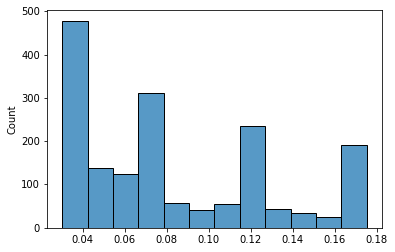

In [27]:
sns.histplot(dataset[0].x[:, 0])

<AxesSubplot:ylabel='Count'>

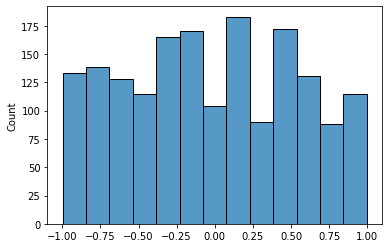

In [28]:
sns.histplot(dataset[0].x[:, 1])

<AxesSubplot:ylabel='Count'>

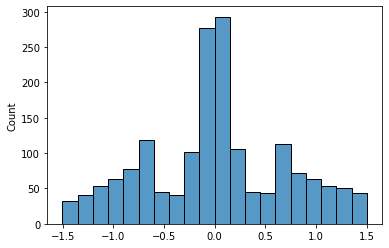

In [29]:
sns.histplot(dataset[0].x[:, 2])

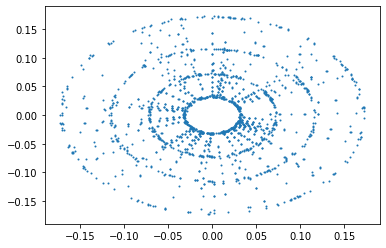

In [33]:
r, phi, z = dataset[0].x[:, 0], dataset[0].x[:, 1]*np.pi, dataset[0].x[:, 2]
plt.scatter(r*np.cos(phi), r*np.sin(phi), s=1)

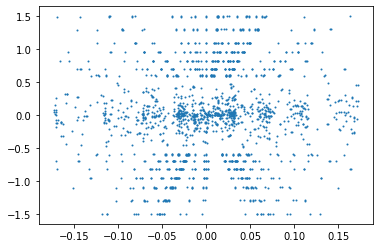

In [34]:
plt.scatter(r*np.cos(phi), z, s=1)

In [49]:
sample = dataset[0]
print(f"Purity: {sample.y.sum() / sample.y.shape[0]}")

## Model

In [4]:
graph_list = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.npz')]
dataset = GraphDataset(graph_files=graph_list)

partition = [100,50]
train_dataset, val_dataset = torch.utils.data.random_split(dataset[:sum(partition)], partition)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1)

In [5]:
model_configs = config['model_configs']
model = EuclidNet(**model_configs).to(device)

In [6]:
optimizer = optim.Adam(model.parameters(), lr=config["training_configs"]["lr"])
scheduler = StepLR(optimizer, step_size=config["training_configs"]["step_size"], gamma=config["training_configs"]["gamma"])

In [7]:
output = {"train_loss": [], "test_loss": [], "test_acc": [], "val_loss": []}
for epoch in range(config['training_configs']['epochs']):
    print(f"---- Epoch {epoch} ----")
    train_loss = train(model, device, train_loader, optimizer, epoch)
    thld, val_loss = validate(model, device, val_loader)
    print(f"...optimal threshold: {thld}")
    scheduler.step()


    output["train_loss"].append(train_loss)
    output["val_loss"].append(val_loss)

---- Epoch 0 ----
Train Epoch: 0 [0/100 (0.000000)]	Loss: 0.698009
Train Epoch: 0 [10/100 (10.000000)]	Loss: 0.429117
Train Epoch: 0 [20/100 (20.000000)]	Loss: 0.363946
Train Epoch: 0 [30/100 (30.000000)]	Loss: 0.360894
Train Epoch: 0 [40/100 (40.000000)]	Loss: 0.394541
Train Epoch: 0 [50/100 (50.000000)]	Loss: 0.319666
Train Epoch: 0 [60/100 (60.000000)]	Loss: 0.342982
Train Epoch: 0 [70/100 (70.000000)]	Loss: 0.360077
Train Epoch: 0 [80/100 (80.000000)]	Loss: 0.293797
Train Epoch: 0 [90/100 (90.000000)]	Loss: 0.340572
...epoch 0: train loss = 0.4022836238145828
...validation accuracy = 0.8743877735884955
...optimal threshold: 0.17669999999999997
---- Epoch 1 ----
Train Epoch: 1 [0/100 (0.000000)]	Loss: 0.395909
Train Epoch: 1 [10/100 (10.000000)]	Loss: 0.310092
Train Epoch: 1 [20/100 (20.000000)]	Loss: 0.396173
Train Epoch: 1 [30/100 (30.000000)]	Loss: 0.331384
Train Epoch: 1 [40/100 (40.000000)]	Loss: 0.335165
Train Epoch: 1 [50/100 (50.000000)]	Loss: 0.301827
Train Epoch: 1 [60/100